(draft)

(very much tentative to changes and additions)

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('0_df_long.csv', sep=';', decimal=',')
df

,KabKot,Tahun,Bulan,Produk,Harga,Kategori,KodeBPS,KodeProv,NamaProv
0,Kab. Aceh Barat,2022,Januari,Beras Premium,11429,Beras,11.05,11,Aceh
1,Kab. Aceh Barat,2022,Januari,Beras Medium,9979,Beras,11.05,11,Aceh
2,Kab. Aceh Barat,2022,Januari,Bawang Merah,31000,Bawang,11.05,11,Aceh
3,Kab. Aceh Barat,2022,Januari,Bawang Putih (Bonggol),28636,Bawang,11.05,11,Aceh
4,Kab. Aceh Barat,2022,Januari,Cabai Merah Keriting,19409,Cabai,11.05,11,Aceh
...,...,...,...,...,...,...,...,...,...
340615,Kota Yogyakarta,2025,Oktober,Minyak Goreng Kemasan,19100,MinyakGoreng,34.71,34,DI Yogyakarta
340616,Kota Yogyakarta,2025,Oktober,Minyak Goreng Curah,17161,MinyakGoreng,34.71,34,DI Yogyakarta
340617,Kota Yogyakarta,2025,Oktober,Jagung Tk. Peternak,NaN,Jagung,34.71,34,DI Yogyakarta
340618,Kota Yogyakarta,2025,Oktober,Cabai Merah Besar,48304,Cabai,34.71,34,DI Yogyakarta


In [3]:
month_map = {
    "Januari":   1,
    "Februari":  2,
    "Maret":     3,
    "April":     4,
    "Mei":       5,
    "Juni":      6,
    "Juli":      7,
    "Agustus":   8,
    "September": 9,
    "Oktober":   10,
    "November":  11,
    "Desember":  12,
}

df["Bulan_norm"] = df["Bulan"].str.strip().str.title()
df["MonthNum"] = df["Bulan_norm"].map(month_map)

df["Tanggal"] = pd.to_datetime(
    dict(year=df["Tahun"].astype(int),
         month=df["MonthNum"].astype(int),
         day=1)
)

df = df.sort_values(["KabKot", "Produk", "Tanggal"]).reset_index(drop=True)
df

,KabKot,Tahun,Bulan,Produk,Harga,Kategori,KodeBPS,KodeProv,NamaProv,Bulan_norm,MonthNum,Tanggal
0,Kab. Aceh Barat,2022,Januari,Bawang Merah,31000,Bawang,11.05,11,Aceh,Januari,1,2022-01-01
1,Kab. Aceh Barat,2022,Februari,Bawang Merah,33107,Bawang,11.05,11,Aceh,Februari,2,2022-02-01
2,Kab. Aceh Barat,2022,Maret,Bawang Merah,37600,Bawang,11.05,11,Aceh,Maret,3,2022-03-01
3,Kab. Aceh Barat,2022,April,Bawang Merah,35800,Bawang,11.05,11,Aceh,April,4,2022-04-01
4,Kab. Aceh Barat,2022,Mei,Bawang Merah,41600,Bawang,11.05,11,Aceh,Mei,5,2022-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...
340615,Kota Yogyakarta,2025,Juni,Telur Ayam Ras,27565,Protein,34.71,34,DI Yogyakarta,Juni,6,2025-06-01
340616,Kota Yogyakarta,2025,Juli,Telur Ayam Ras,27486,Protein,34.71,34,DI Yogyakarta,Juli,7,2025-07-01
340617,Kota Yogyakarta,2025,Agustus,Telur Ayam Ras,26903,Protein,34.71,34,DI Yogyakarta,Agustus,8,2025-08-01
340618,Kota Yogyakarta,2025,September,Telur Ayam Ras,27413,Protein,34.71,34,DI Yogyakarta,September,9,2025-09-01


## Handling NaN Values

In [4]:
def fill_harga(group):
    group = group.sort_values("Tanggal").copy()

    s = group["Harga"].astype("float64").copy()

    if pd.isna(s.iloc[0]):
        s.iloc[0] = s.bfill().iloc[0]

    vals = s.to_numpy(dtype="float64")
    n = len(vals)
    i = 0

    while i < n:
        if np.isnan(vals[i]):
            start = i
            while i < n and np.isnan(vals[i]):
                i += 1
            end = i - 1

            prev_val = vals[start - 1] if start > 0 and not np.isnan(vals[start - 1]) else None
            next_val = vals[i] if i < n and not np.isnan(vals[i]) else None

            if prev_val is not None and next_val is not None:
                fill_val = (prev_val + next_val) / 2.0
            elif prev_val is not None:
                fill_val = prev_val
            elif next_val is not None:
                fill_val = next_val
            else:
                fill_val = np.nan

            vals[start:end+1] = fill_val
        else:
            i += 1

    group["Harga_filled"] = vals
    return group

In [5]:
group_cols = ["KabKot", "Produk"]

df = (
    df
    .groupby(group_cols, group_keys=False)[df.columns]
    .apply(fill_harga)
)

df["Harga"] = df["Harga_filled"]
df = df.drop(columns=["Harga_filled", "Bulan_norm", "MonthNum"])
df

,KabKot,Tahun,Bulan,Produk,Harga,Kategori,KodeBPS,KodeProv,NamaProv,Tanggal
0,Kab. Aceh Barat,2022,Januari,Bawang Merah,31000.0,Bawang,11.05,11,Aceh,2022-01-01
1,Kab. Aceh Barat,2022,Februari,Bawang Merah,33107.0,Bawang,11.05,11,Aceh,2022-02-01
2,Kab. Aceh Barat,2022,Maret,Bawang Merah,37600.0,Bawang,11.05,11,Aceh,2022-03-01
3,Kab. Aceh Barat,2022,April,Bawang Merah,35800.0,Bawang,11.05,11,Aceh,2022-04-01
4,Kab. Aceh Barat,2022,Mei,Bawang Merah,41600.0,Bawang,11.05,11,Aceh,2022-05-01
...,...,...,...,...,...,...,...,...,...,...
340615,Kota Yogyakarta,2025,Juni,Telur Ayam Ras,27565.0,Protein,34.71,34,DI Yogyakarta,2025-06-01
340616,Kota Yogyakarta,2025,Juli,Telur Ayam Ras,27486.0,Protein,34.71,34,DI Yogyakarta,2025-07-01
340617,Kota Yogyakarta,2025,Agustus,Telur Ayam Ras,26903.0,Protein,34.71,34,DI Yogyakarta,2025-08-01
340618,Kota Yogyakarta,2025,September,Telur Ayam Ras,27413.0,Protein,34.71,34,DI Yogyakarta,2025-09-01


In [6]:
df["Harga"].isna().sum()


np.int64(8896)

In [7]:
df.groupby(["KabKot", "Produk"])["Harga"].apply(lambda s: s.isna().sum()).sort_values(ascending=False)


KabKot                  Produk               
Kab. Bangka Barat       Jagung Tk. Peternak      46
Kab. Kepulauan Anambas  Jagung Tk. Peternak      46
Kota Padangsidimpuan    Cabai Merah Besar        46
Kab. Aceh Tenggara      Cabai Merah Besar        46
Kab. Gorontalo Utara    Jagung Tk. Peternak      46
                                                 ..
Kota Yogyakarta         Jagung Tk. Peternak       0
                        Minyak Goreng Curah       0
                        Minyak Goreng Kemasan     0
                        Minyakita                 0
                        Telur Ayam Ras            0
Name: Harga, Length: 7590, dtype: int64

In [8]:
all_nan_groups = (
    df.groupby(["KabKot", "Produk"])["Harga"]
      .apply(lambda s: s.isna().all())
)

print(all_nan_groups.index.tolist())


[('Kab. Aceh Barat', 'Bawang Merah'), ('Kab. Aceh Barat', 'Bawang Putih (Bonggol)'), ('Kab. Aceh Barat', 'Beras Medium'), ('Kab. Aceh Barat', 'Beras Premium'), ('Kab. Aceh Barat', 'Cabai Merah Besar'), ('Kab. Aceh Barat', 'Cabai Merah Keriting'), ('Kab. Aceh Barat', 'Cabai Rawit Merah'), ('Kab. Aceh Barat', 'Daging Ayam Ras'), ('Kab. Aceh Barat', 'Daging Sapi Murni'), ('Kab. Aceh Barat', 'Gula Konsumsi'), ('Kab. Aceh Barat', 'Jagung Tk. Peternak'), ('Kab. Aceh Barat', 'Minyak Goreng Curah'), ('Kab. Aceh Barat', 'Minyak Goreng Kemasan'), ('Kab. Aceh Barat', 'Minyakita'), ('Kab. Aceh Barat', 'Telur Ayam Ras'), ('Kab. Aceh Barat Daya', 'Bawang Merah'), ('Kab. Aceh Barat Daya', 'Bawang Putih (Bonggol)'), ('Kab. Aceh Barat Daya', 'Beras Medium'), ('Kab. Aceh Barat Daya', 'Beras Premium'), ('Kab. Aceh Barat Daya', 'Cabai Merah Besar'), ('Kab. Aceh Barat Daya', 'Cabai Merah Keriting'), ('Kab. Aceh Barat Daya', 'Cabai Rawit Merah'), ('Kab. Aceh Barat Daya', 'Daging Ayam Ras'), ('Kab. Aceh Bara

In [9]:
total_nan = df["Harga"].isna().sum()

nan_in_all_nan_groups = (
    df.groupby(["KabKot", "Produk"])["Harga"]
      .apply(lambda s: s.isna().sum() if s.isna().all() else 0)
      .sum()
)

print("Total NaN in Harga:", total_nan)
print("NaN in all-NaN groups:", nan_in_all_nan_groups)


Total NaN in Harga: 8896
NaN in all-NaN groups: 8896


In [10]:
fully_nan_index = all_nan_groups[all_nan_groups].index   # MultiIndex of combos to drop

df = df[~df.set_index(["KabKot", "Produk"]).index.isin(fully_nan_index)].reset_index(drop=True)

print("Remaining NaNs:", df["Harga"].isna().sum())


Remaining NaNs: 0


## Aggregate by Province

In [11]:
df_prov = (
    df.groupby(["NamaProv", "Produk", "Tanggal", "Kategori"], as_index=False)["Harga"]
      .mean()
      .rename(columns={"Harga": "Harga_prov"})
)
df_prov


,NamaProv,Produk,Tanggal,Kategori,Harga_prov
0,Aceh,Bawang Merah,2022-01-01,Bawang,30192.956522
1,Aceh,Bawang Merah,2022-02-01,Bawang,32474.956522
2,Aceh,Bawang Merah,2022-03-01,Bawang,36235.913043
3,Aceh,Bawang Merah,2022-04-01,Bawang,34477.695652
4,Aceh,Bawang Merah,2022-05-01,Bawang,37444.173913
...,...,...,...,...,...
22765,Sumatera Utara,Telur Ayam Ras,2025-06-01,Protein,28156.242424
22766,Sumatera Utara,Telur Ayam Ras,2025-07-01,Protein,28483.484848
22767,Sumatera Utara,Telur Ayam Ras,2025-08-01,Protein,29128.515152
22768,Sumatera Utara,Telur Ayam Ras,2025-09-01,Protein,28886.606061


## Aggregate by Category (except Protein)

In [12]:
kat_norm = df_prov["Kategori"].str.strip().str.lower()

df_prov["KatAgg"] = np.where(
    kat_norm == "protein",
    df_prov["Produk"],
    df_prov["Kategori"]
)

df_prov["KatAgg"].value_counts()

KatAgg
Cabai                4554
MinyakGoreng         4554
Bawang               3036
Beras                3036
Daging Ayam Ras      1518
Daging Sapi Murni    1518
Gula                 1518
Jagung               1518
Telur Ayam Ras       1518
Name: count, dtype: int64

In [13]:
df_prov_kat = (
    df_prov
    .groupby(["NamaProv", "KatAgg", "Tanggal"], as_index=False)["Harga_prov"]
    .mean()
)

df_prov_kat = df_prov_kat.rename(columns={"KatAgg": "KategoriAgg", "Harga_prov": "Harga"})

df_prov_kat

,NamaProv,KategoriAgg,Tanggal,Harga
0,Aceh,Bawang,2022-01-01,29488.130435
1,Aceh,Bawang,2022-02-01,31136.891304
2,Aceh,Bawang,2022-03-01,33484.847826
3,Aceh,Bawang,2022-04-01,32411.413043
4,Aceh,Bawang,2022-05-01,33122.065217
...,...,...,...,...
13657,Sumatera Utara,Telur Ayam Ras,2025-06-01,28156.242424
13658,Sumatera Utara,Telur Ayam Ras,2025-07-01,28483.484848
13659,Sumatera Utara,Telur Ayam Ras,2025-08-01,29128.515152
13660,Sumatera Utara,Telur Ayam Ras,2025-09-01,28886.606061


## Check for Variable Redundancy

In [14]:
kategori_vars = [
    "Cabai",
    "MinyakGoreng",
    "Bawang",
    "Beras",
    "Daging Ayam Ras",
    "Daging Sapi Murni",
    "Gula",
    "Jagung",
    "Telur Ayam Ras",
]

df_sub = df_prov_kat[df_prov_kat["KategoriAgg"].isin(kategori_vars)].copy()

df_wide = (
    df_sub
    .pivot_table(
        index=["NamaProv", "Tanggal"],
        columns="KategoriAgg",
        values="Harga",
        aggfunc="mean"
    )
)

df_wide = df_wide.dropna(how="any")

corr_matrix = df_wide[kategori_vars].corr()
corr_matrix


KategoriAgg,Cabai,MinyakGoreng,Bawang,Beras,Daging Ayam Ras,Daging Sapi Murni,Gula,Jagung,Telur Ayam Ras
KategoriAgg,,,,,,,,,
Cabai,1.000000,0.341807,0.419428,0.409266,0.582020,0.359160,0.245084,0.257700,0.505344
MinyakGoreng,0.341807,1.000000,0.638910,0.346374,0.579553,-0.074827,0.446906,0.235460,0.531419
Bawang,0.419428,0.638910,1.000000,0.646942,0.529367,0.203866,0.706391,0.434354,0.728965
Beras,0.409266,0.346374,0.646942,1.000000,0.452337,0.340717,0.835462,0.330798,0.676784
Daging Ayam Ras,0.582020,0.579553,0.529367,0.452337,1.000000,0.043792,0.321207,0.230541,0.735241
Daging Sapi Murni,0.359160,-0.074827,0.203866,0.340717,0.043792,1.000000,0.130257,0.299674,0.194776
Gula,0.245084,0.446906,0.706391,0.835462,0.321207,0.130257,1.000000,0.333975,0.557863
Jagung,0.257700,0.235460,0.434354,0.330798,0.230541,0.299674,0.333975,1.000000,0.460330
Telur Ayam Ras,0.505344,0.531419,0.728965,0.676784,0.735241,0.194776,0.557863,0.460330,1.000000


## Clustering by Province for the 3 Staples in Indonesia (Beras, Minyak Goreng, Gula)

In [15]:
df_mean = (
    df_prov_kat
    .groupby(["NamaProv", "KategoriAgg"], as_index=False)["Harga"]
    .mean()
)
df_mean

,NamaProv,KategoriAgg,Harga
0,Aceh,Bawang,36063.788280
1,Aceh,Beras,13106.139650
2,Aceh,Cabai,54320.470857
3,Aceh,Daging Ayam Ras,31000.022684
4,Aceh,Daging Sapi Murni,155159.618620
...,...,...,...
292,Sumatera Utara,Daging Sapi Murni,134226.774909
293,Sumatera Utara,Gula,16340.874197
294,Sumatera Utara,Jagung,6470.319221
295,Sumatera Utara,MinyakGoreng,17513.059855


In [16]:
df_mean['NamaProv'].unique()

array(['Aceh', 'Bali', 'Banten', 'Bengkulu', 'DI Yogyakarta',
       'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah',
       'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
       'Kalimantan Tengah', 'Kalimantan Timur',
       'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung', 'Maluku',
       'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Papua', 'Papua Barat', 'Riau', 'Sulawesi Barat',
       'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara',
       'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan',
       'Sumatera Utara'], dtype=object)

In [17]:
kategori_vars = [
    "Cabai",
    "MinyakGoreng",
    "Bawang",
    "Beras",
    "Daging Ayam Ras",
    "Daging Sapi Murni",
    "Gula",
    "Jagung",
    "Telur Ayam Ras",
]

df_wide = (
    df_mean
    .pivot(index="NamaProv", columns="KategoriAgg", values="Harga")
    .reindex(columns=kategori_vars)
    .dropna(how="any")
)
df_wide

KategoriAgg,Cabai,MinyakGoreng,Bawang,Beras,Daging Ayam Ras,Daging Sapi Murni,Gula,Jagung,Telur Ayam Ras
NamaProv,,,,,,,,,
Aceh,54320.470857,17458.559861,36063.788280,13106.139650,31000.022684,155159.618620,16595.759924,9749.590062,25510.955577
Bali,49871.663446,17570.915459,30700.663043,13471.057971,39119.442029,116455.262077,15703.053140,6403.250000,26648.654589
Banten,54000.285326,16630.185688,35433.302989,12640.846467,36883.491848,135418.877717,15886.100543,7569.690217,27538.630435
Bengkulu,48277.342874,17145.202174,35810.206522,13094.213043,35562.250000,135652.913043,16154.930435,8322.077899,26252.504348
DI Yogyakarta,48319.818841,16605.723188,32676.954348,12668.128261,34110.934783,135182.600000,15521.795652,7225.254348,26933.243478
DKI Jakarta,61785.514010,18089.926087,41348.268116,13221.505435,38442.547101,138140.181159,16441.163043,12000.000000,28494.902174
Gorontalo,43609.997585,17993.580314,40780.827899,13233.320652,32144.090580,134322.250000,16974.612319,21000.000000,31204.420290
Jambi,47516.979513,16742.265810,32013.446640,12979.431818,34038.357708,137639.837945,15931.023715,7081.027950,27529.211462
Jawa Barat,54069.657903,17680.000939,34949.324074,12789.855878,36230.452496,133186.580918,16070.256844,6844.207776,27940.276973


In [ ]:
df_wide = df_wide[["Beras", "Gula", "MinyakGoreng"]]
df_wide

KategoriAgg,Beras,Gula,MinyakGoreng
NamaProv,,,
Aceh,13106.139650,16595.759924,17458.559861
Bali,13471.057971,15703.053140,17570.915459
Banten,12640.846467,15886.100543,16630.185688
Bengkulu,13094.213043,16154.930435,17145.202174
DI Yogyakarta,12668.128261,15521.795652,16605.723188
DKI Jakarta,13221.505435,16441.163043,18089.926087
Gorontalo,13233.320652,16974.612319,17993.580314
Jambi,12979.431818,15931.023715,16742.265810
Jawa Barat,12789.855878,16070.256844,17680.000939


### Quick EDA

Shape: (33, 3)

Index name: NamaProv
Columns: ['Beras', 'MinyakGoreng', 'Gula']

Head:
KategoriAgg           Beras  MinyakGoreng          Gula
NamaProv                                               
Aceh           13106.139650  17458.559861  16595.759924
Bali           13471.057971  17570.915459  15703.053140
Banten         12640.846467  16630.185688  15886.100543
Bengkulu       13094.213043  17145.202174  16154.930435
DI Yogyakarta  12668.128261  16605.723188  15521.795652

Basic info:
<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, Aceh to Sumatera Utara
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Beras         33 non-null     float64
 1   MinyakGoreng  33 non-null     float64
 2   Gula          33 non-null     float64
dtypes: float64(3)
memory usage: 1.0+ KB
None

Missing values per column:
KategoriAgg
Beras           0
MinyakGoreng    0
Gula            0
dtype: int64

Descriptive statistics:
   

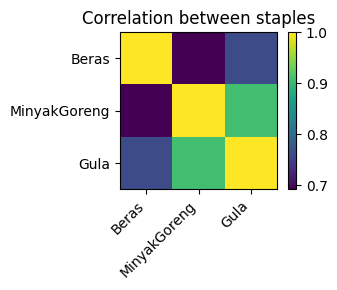

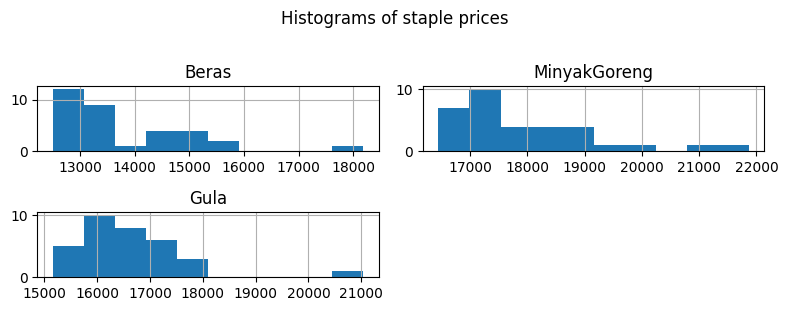

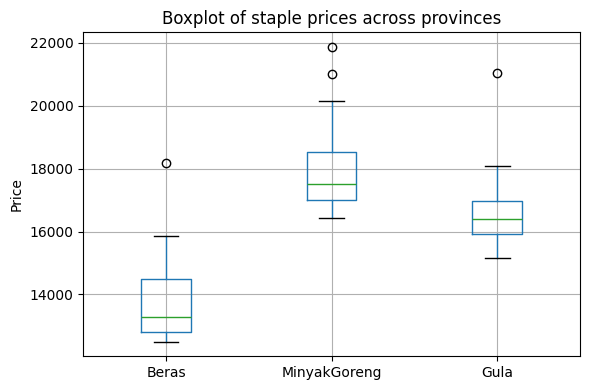

<Figure size 600x600 with 0 Axes>

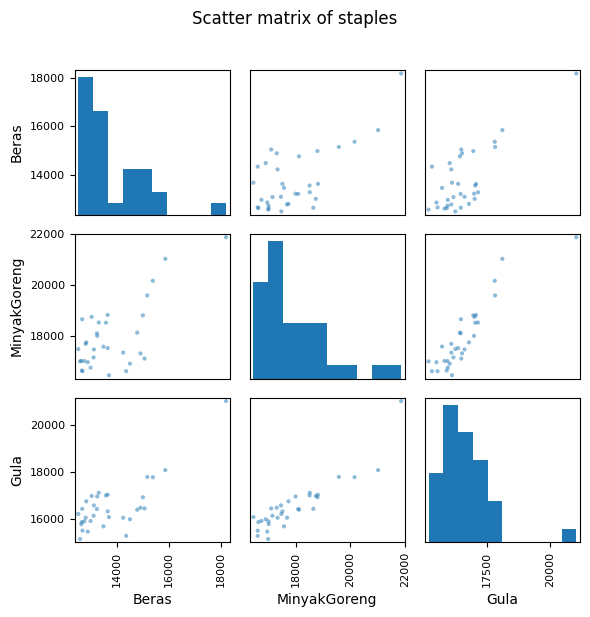

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# =========================
# 1. Basic structure
# =========================
print("Shape:", df_wide.shape)
print("\nIndex name:", df_wide.index.name)
print("Columns:", df_wide.columns.tolist())

print("\nHead:")
print(df_wide.head())

print("\nBasic info:")
print(df_wide.info())

# =========================
# 2. Missing values
# =========================
print("\nMissing values per column:")
print(df_wide.isna().sum())

# =========================
# 3. Summary statistics
# =========================
print("\nDescriptive statistics:")
print(df_wide.describe().T)  # transpose for readability

# =========================
# 4. Correlation between staples
# =========================
corr = df_wide.corr()
print("\nCorrelation matrix:")
print(corr)

plt.figure(figsize=(4, 3))
im = plt.imshow(corr, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation between staples")
plt.tight_layout()
plt.show()

# =========================
# 5. Distributions (histograms)
# =========================
df_wide.hist(figsize=(8, 3), bins=10)
plt.suptitle("Histograms of staple prices", y=1.02)
plt.tight_layout()
plt.show()

# =========================
# 6. Boxplots per variable
# =========================
plt.figure(figsize=(6, 4))
df_wide.boxplot()
plt.title("Boxplot of staple prices across provinces")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# =========================
# 7. Scatter matrix (pairwise scatter plots)
# =========================
plt.figure(figsize=(6, 6))
scatter_matrix(df_wide, figsize=(6, 6), diagonal="hist")
plt.suptitle("Scatter matrix of staples", y=1.02)
plt.tight_layout()
plt.show()


# Interpretasi EDA

## 1. Struktur Data

- Jumlah observasi: **33 provinsi**.
- Variabel:
  - **Beras**
  - **MinyakGoreng**
  - **Gula**
- Tidak ada nilai hilang (missing value) pada ketiga variabel tersebut.

Artinya, analisis dapat langsung dilakukan tanpa perlu imputasi atau pembersihan tambahan di level provinsi.

---

## 2. Gambaran Umum Tingkat Harga

Ringkasan statistik (dalam satuan harga rata-rata selama periode pengamatan):

- **Beras**
  - Rata-rata: ± **13.763**
  - Sebaran (std): ± 1.246
  - Rentang: dari sekitar **12.504** sampai **18.183**

- **MinyakGoreng**
  - Rata-rata: ± **17.910**
  - Sebaran (std): ± 1.280
  - Rentang: dari sekitar **16.446** sampai **21.866**

- **Gula**
  - Rata-rata: ± **16.550**
  - Sebaran (std): ± 1.069
  - Rentang: dari sekitar **15.164** sampai **21.035**

Secara umum:
- Minyak goreng memiliki **level harga rata-rata tertinggi** di antara tiga komoditas pokok.
- Beras merupakan komoditas dengan **level harga rata-rata terendah**, namun tetap menunjukkan variasi antardaerah yang cukup terasa.
- Gula berada di tengah-tengah, baik dari sisi rata-rata maupun sebaran.

Outlier terlihat pada beberapa provinsi dengan harga jauh di atas rata-rata, terutama:
- Beras di kisaran > 17–18 ribu,
- Minyak goreng di kisaran > 20–21 ribu,
- Gula di kisaran > 19–21 ribu.

Ini menunjukkan adanya beberapa provinsi dengan **beban harga pangan yang jauh lebih tinggi** dibanding provinsi lain.

---

## 3. Distribusi Harga antar Provinsi

Dari histogram dan boxplot:

- **Beras**
  - Distribusi sedikit condong ke kanan (right-skewed): sebagian besar provinsi berada di kisaran 12–14 ribu, dengan beberapa provinsi yang jauh lebih mahal sehingga menjadi outlier.
  - Menunjukkan bahwa **mayoritas provinsi memiliki harga beras relatif terkendali**, namun ada sedikit kelompok yang benar-benar mahal.

- **MinyakGoreng**
  - Distribusi juga condong ke kanan, dengan beberapa titik outlier di atas 20 ribu.
  - Menunjukkan adanya **ketimpangan harga minyak goreng** yang cukup jelas antarprovinsi.

- **Gula**
  - Pola mirip: mayoritas provinsi di sekitar 15,5–17 ribu, dengan sedikit provinsi yang sangat mahal.
  - Ini konsisten dengan komoditas yang diawasi ketat, tetapi tetap ada variasi cukup lebar di daerah tertentu.

Secara praktis, ketiga komoditas menunjukkan pola bahwa **sebagian besar provinsi berada di “cluster harga tengah”**, sedangkan sejumlah kecil provinsi “menarik” ekor distribusi ke arah harga tinggi.

---

## 4. Korelasi Antar Komoditas

Matriks korelasi menunjukkan:

- **Beras – MinyakGoreng**: ~ **0.69**
- **Beras – Gula**: ~ **0.76**
- **MinyakGoreng – Gula**: ~ **0.91** (sangat tinggi)

Interpretasi:

1. Korelasi positif yang cukup kuat antar semua pasangan komoditas menunjukkan bahwa:
   - Provinsi yang **mahal di satu komoditas** cenderung **mahal juga** di komoditas lainnya.
   - Ada indikasi **pola umum biaya hidup pangan pokok** yang bergerak bersama.

2. Korelasi yang **paling kuat** adalah antara **MinyakGoreng dan Gula (~0.91)**:
   - Mengindikasikan bahwa kedua komoditas ini sangat sejalan dalam hal tingkat harga antarprovinsi.
   - Provinsi yang mengalami kenaikan harga minyak goreng hampir selalu juga memiliki harga gula yang relatif tinggi.

3. Beras juga berkorelasi kuat dengan Gula dan MinyakGoreng, meskipun sedikit lebih rendah dibanding hubungan minyak–gula:
   - Ini mendukung interpretasi bahwa ketiga komoditas tersebut bersama-sama dapat dijadikan indikator **keterjangkauan pangan pokok** di tingkat provinsi.


### K-Means clustering

In [29]:
from sklearn.preprocessing import StandardScaler

X = df_wide.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

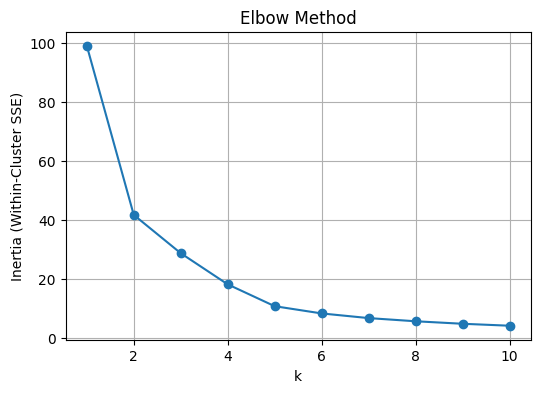

In [30]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()


In [31]:
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

sil_scores


{2: 0.6330350594788052,
 3: 0.5238814464300645,
 4: 0.348344920706667,
 5: 0.4254056180778093,
 6: 0.39609971509347314,
 7: 0.3543051450804735,
 8: 0.32965281864437873,
 9: 0.3463317014244102,
 10: 0.31335748127390683}

In [37]:
best_k = 3

kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=0)
labels = kmeans.fit_predict(X_scaled)


In [38]:
df_clusters = df_wide.copy()
df_clusters["cluster"] = labels
df_clusters_reset = df_clusters.reset_index()


In [39]:
cluster_profile = (
    df_clusters
    .groupby("cluster")[df_wide.columns]
    .mean()
)

cluster_profile


KategoriAgg,Beras,Gula,MinyakGoreng
cluster,,,
0,18182.524093,21035.431396,21865.976632
1,13379.110819,16231.243079,17486.203535
2,15341.410204,17660.843069,19888.039909


In [41]:
df_clusters = df_wide.copy()
df_clusters["cluster"] = labels
df_clusters_reset = df_clusters.reset_index()


In [42]:
df_clusters_reset

KategoriAgg,NamaProv,Beras,Gula,MinyakGoreng,cluster
0,Aceh,13106.139650,16595.759924,17458.559861,1
1,Bali,13471.057971,15703.053140,17570.915459,1
2,Banten,12640.846467,15886.100543,16630.185688,1
3,Bengkulu,13094.213043,16154.930435,17145.202174,1
4,DI Yogyakarta,12668.128261,15521.795652,16605.723188,1
5,DKI Jakarta,13221.505435,16441.163043,18089.926087,1
6,Gorontalo,13233.320652,16974.612319,17993.580314,1
7,Jambi,12979.431818,15931.023715,16742.265810,1
8,Jawa Barat,12789.855878,16070.256844,17680.000939,1
9,Jawa Tengah,12870.308925,15479.226400,16955.915238,1


### K-medoids

In [46]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

def k_medoids_pam(X, n_clusters, metric="euclidean", max_iter=300, random_state=None):
    """
    Simple K-medoids (PAM) implementation.
    X: (n_samples, n_features)
    Returns:
        labels: (n_samples,) cluster labels
        medoid_indices: list of indices of chosen medoids
        inertia: sum of distances of each point to its assigned medoid
    """
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]

    # precompute distance matrix
    D = pairwise_distances(X, metric=metric)

    # --- init: pick n_clusters distinct random medoids ---
    medoid_indices = rng.choice(n_samples, size=n_clusters, replace=False)
    medoid_indices = np.sort(medoid_indices)

    for _ in range(max_iter):
        # assign each point to nearest medoid
        distances_to_medoids = D[:, medoid_indices]          # (n_samples, k)
        labels = distances_to_medoids.argmin(axis=1)

        new_medoids = medoid_indices.copy()

        # update step: for each cluster, choose the point that minimizes total distance in that cluster
        for k in range(n_clusters):
            cluster_points = np.where(labels == k)[0]
            if len(cluster_points) == 0:
                # empty cluster: reinitialize medoid randomly
                non_medoids = np.setdiff1d(np.arange(n_samples), new_medoids)
                if len(non_medoids) > 0:
                    new_medoids[k] = rng.choice(non_medoids)
                continue

            # distances within the cluster
            D_cluster = D[np.ix_(cluster_points, cluster_points)]
            # total distance from each point to others in cluster
            total_dist = D_cluster.sum(axis=1)
            # pick cluster point with minimum total distance as new medoid
            best_idx_in_cluster = cluster_points[total_dist.argmin()]
            new_medoids[k] = best_idx_in_cluster

        new_medoids = np.sort(new_medoids)

        # stop if medoids don't change
        if np.array_equal(new_medoids, medoid_indices):
            break

        medoid_indices = new_medoids

    # final assignment and inertia
    distances_to_medoids = D[:, medoid_indices]
    labels = distances_to_medoids.argmin(axis=1)
    inertia = distances_to_medoids.min(axis=1).sum()

    return labels, medoid_indices, inertia


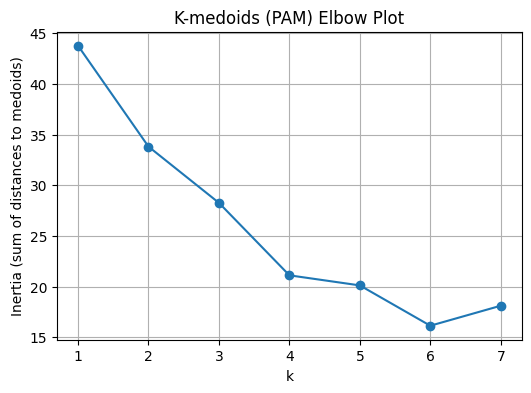

In [47]:
inertias = []
K_range = range(1, 8)

for k in K_range:
    labels_k, medoids_k, inertia_k = k_medoids_pam(
        X_scaled,
        n_clusters=k,
        metric="euclidean",
        max_iter=300,
        random_state=0
    )
    inertias.append(inertia_k)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (sum of distances to medoids)")
plt.title("K-medoids (PAM) Elbow Plot")
plt.grid(True)
plt.show()


In [48]:
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 8):
    labels_k, medoids_k, inertia_k = k_medoids_pam(
        X_scaled,
        n_clusters=k,
        metric="euclidean",
        max_iter=300,
        random_state=0
    )
    sil = silhouette_score(X_scaled, labels_k)
    sil_scores[k] = sil

sil_scores


{2: 0.39932670456977254,
 3: 0.25519394309810217,
 4: 0.39891511660740975,
 5: 0.2821516691715415,
 6: 0.3488234525764815,
 7: 0.14955119043901846}

In [50]:
best_k = 4
labels, medoid_indices, inertia = k_medoids_pam(
    X_scaled,
    n_clusters=best_k,
    metric="euclidean",
    max_iter=300,
    random_state=0
)

df_kmed = df_wide.copy()
df_kmed["cluster_kmed"] = labels
df_kmed_reset = df_kmed.reset_index()  # bring NamaProv out


In [52]:
prov_names = df_wide.index.to_list()
medoid_provinces = [prov_names[i] for i in medoid_indices]
medoid_provinces


['Gorontalo', 'Kalimantan Selatan', 'Lampung', 'Maluku Utara']

In [53]:
cluster_profile_kmed = (
    df_kmed
    .groupby("cluster_kmed")[df_wide.columns]
    .mean()
)
cluster_profile_kmed


KategoriAgg,Beras,Gula,MinyakGoreng
cluster_kmed,,,
0,13218.642781,16777.169978,18200.498959
1,14496.290563,16120.696394,17115.136529
2,12814.058290,15805.293789,17072.977608
3,15909.632981,18335.760735,20283.627253


In [54]:
df_kmed_reset[["NamaProv", "cluster_kmed"]].sort_values("cluster_kmed")


KategoriAgg,NamaProv,cluster_kmed
0,Aceh,0
5,DKI Jakarta,0
6,Gorontalo,0
28,Sulawesi Tenggara,0
25,Sulawesi Barat,0
27,Sulawesi Tengah,0
20,Nusa Tenggara Barat,0
21,Nusa Tenggara Timur,0
29,Sulawesi Utara,0
32,Sumatera Utara,0


## Evaluation of the 2 Clustering Methods

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    pairwise_distances,
)

# 1. Choose the very core staples
staples = ["Beras", "MinyakGoreng", "Gula"]

# keep only staple categories
df_staple = df_prov_kat[df_prov_kat["KategoriAgg"].isin(staples)].copy()

# 2. Aggregate over time: mean Harga per (NamaProv, KategoriAgg)
df_mean = (
    df_staple
    .groupby(["NamaProv", "KategoriAgg"], as_index=False)["Harga"]
    .mean()
)

# 3. Pivot to wide: each row = province, each col = staple
df_wide = (
    df_mean
    .pivot(index="NamaProv", columns="KategoriAgg", values="Harga")
    .reindex(columns=staples)
)

# drop provinces that are missing any staple (should be rare)
df_wide = df_wide.dropna(how="any")

# keep a copy of province names
prov_names = df_wide.index.to_list()

# 4. Standardize features
X = df_wide.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------
# 5. K-medoids implementation (PAM) – no sklearn-extra needed
# ---------------------------------------------------------
def k_medoids_pam(X, n_clusters, metric="euclidean", max_iter=300, random_state=None):
    """
    Simple K-medoids (PAM) implementation.
    X: (n_samples, n_features)
    Returns:
        labels: (n_samples,) cluster labels
        medoid_indices: list of indices of chosen medoids
        inertia: sum of distances of each point to its assigned medoid
    """
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]

    # precompute distance matrix
    D = pairwise_distances(X, metric=metric)

    # init: pick n_clusters distinct random medoids
    medoid_indices = rng.choice(n_samples, size=n_clusters, replace=False)
    medoid_indices = np.sort(medoid_indices)

    for _ in range(max_iter):
        # assign each point to nearest medoid
        distances_to_medoids = D[:, medoid_indices]  # (n_samples, k)
        labels = distances_to_medoids.argmin(axis=1)

        new_medoids = medoid_indices.copy()

        # update: for each cluster, choose point minimizing total distance in that cluster
        for k in range(n_clusters):
            cluster_points = np.where(labels == k)[0]
            if len(cluster_points) == 0:
                # empty cluster: reinit medoid randomly
                non_medoids = np.setdiff1d(np.arange(n_samples), new_medoids)
                if len(non_medoids) > 0:
                    new_medoids[k] = rng.choice(non_medoids)
                continue

            D_cluster = D[np.ix_(cluster_points, cluster_points)]
            total_dist = D_cluster.sum(axis=1)
            best_idx_in_cluster = cluster_points[total_dist.argmin()]
            new_medoids[k] = best_idx_in_cluster

        new_medoids = np.sort(new_medoids)
        if np.array_equal(new_medoids, medoid_indices):
            break

        medoid_indices = new_medoids

    distances_to_medoids = D[:, medoid_indices]
    labels = distances_to_medoids.argmin(axis=1)
    inertia = distances_to_medoids.min(axis=1).sum()

    return labels, medoid_indices, inertia

# ---------------------------------------------------------
# 6. Run final models: KMeans (k=3), K-medoids (k=4)
# ---------------------------------------------------------

# KMeans with k=3
k_kmeans = 3
kmeans = KMeans(n_clusters=k_kmeans, n_init=20, random_state=0)
labels_kmeans = kmeans.fit_predict(X_scaled)

# K-medoids with k=4
k_kmedoids = 4
labels_kmedoids, medoid_indices, inertia_kmed = k_medoids_pam(
    X_scaled,
    n_clusters=k_kmedoids,
    metric="euclidean",
    max_iter=300,
    random_state=0
)

# ---------------------------------------------------------
# 7. Evaluate performance of each clustering
# ---------------------------------------------------------

# KMeans metrics
sil_km = silhouette_score(X_scaled, labels_kmeans)
ch_km = calinski_harabasz_score(X_scaled, labels_kmeans)
db_km = davies_bouldin_score(X_scaled, labels_kmeans)

# K-medoids metrics
sil_kmed = silhouette_score(X_scaled, labels_kmedoids)
ch_kmed = calinski_harabasz_score(X_scaled, labels_kmedoids)
db_kmed = davies_bouldin_score(X_scaled, labels_kmedoids)

print("=== KMeans (k=3) ===")
print(f"Silhouette score        : {sil_km:.4f}")
print(f"Calinski-Harabasz index : {ch_km:.4f}")
print(f"Davies-Bouldin index    : {db_km:.4f}")

print("\n=== K-medoids (k=4) ===")
print(f"Silhouette score        : {sil_kmed:.4f}")
print(f"Calinski-Harabasz index : {ch_kmed:.4f}")
print(f"Davies-Bouldin index    : {db_kmed:.4f}")

# ---------------------------------------------------------
# 8. Build a single df with everything
# ---------------------------------------------------------
df_all = df_wide.copy()
df_all["cluster_kmeans"] = labels_kmeans
df_all["cluster_kmedoids"] = labels_kmedoids

# mark medoids
df_all["is_medoid_kmedoids"] = False
df_all.iloc[medoid_indices, df_all.columns.get_loc("is_medoid_kmedoids")] = True

# bring NamaProv back as a column
df_all = df_all.reset_index()  # columns: NamaProv, Beras, MinyakGoreng, Gula, cluster_kmeans, cluster_kmedoids, is_medoid_kmedoids

df_all


=== KMeans (k=3) ===
Silhouette score        : 0.5239
Calinski-Harabasz index : 36.9209
Davies-Bouldin index    : 0.4310

=== K-medoids (k=4) ===
Silhouette score        : 0.3989
Calinski-Harabasz index : 28.3010
Davies-Bouldin index    : 0.7159

=== Head of combined clustering df (df_all) ===
KategoriAgg       NamaProv         Beras  MinyakGoreng          Gula  \
0                     Aceh  13106.139650  17458.559861  16595.759924   
1                     Bali  13471.057971  17570.915459  15703.053140   
2                   Banten  12640.846467  16630.185688  15886.100543   
3                 Bengkulu  13094.213043  17145.202174  16154.930435   
4            DI Yogyakarta  12668.128261  16605.723188  15521.795652   

KategoriAgg  cluster_kmeans  cluster_kmedoids  is_medoid_kmedoids  
0                         1                 0               False  
1                         1                 2               False  
2                         1                 2               False  


KategoriAgg,NamaProv,Beras,MinyakGoreng,Gula,cluster_kmeans,cluster_kmedoids,is_medoid_kmedoids
0,Aceh,13106.139650,17458.559861,16595.759924,1,0,False
1,Bali,13471.057971,17570.915459,15703.053140,1,2,False
2,Banten,12640.846467,16630.185688,15886.100543,1,2,False
3,Bengkulu,13094.213043,17145.202174,16154.930435,1,2,False
4,DI Yogyakarta,12668.128261,16605.723188,15521.795652,1,2,False
5,DKI Jakarta,13221.505435,18089.926087,16441.163043,1,0,False
6,Gorontalo,13233.320652,17993.580314,16974.612319,1,0,True
7,Jambi,12979.431818,16742.265810,15931.023715,1,2,False
8,Jawa Barat,12789.855878,17680.000939,16070.256844,1,2,False
9,Jawa Tengah,12870.308925,16955.915238,15479.226400,1,2,False


In [60]:
df_all.groupby("cluster_kmeans")[["Beras", "MinyakGoreng", "Gula"]].mean()


KategoriAgg,Beras,MinyakGoreng,Gula
cluster_kmeans,,,
0,18182.524093,21865.976632,21035.431396
1,13379.110819,17486.203535,16231.243079
2,15341.410204,19888.039909,17660.843069


In [61]:
df_all.groupby("cluster_kmedoids")[["Beras", "MinyakGoreng", "Gula"]].mean()

KategoriAgg,Beras,MinyakGoreng,Gula
cluster_kmedoids,,,
0,13218.642781,18200.498959,16777.169978
1,14496.290563,17115.136529,16120.696394
2,12814.058290,17072.977608,15805.293789
3,15909.632981,20283.627253,18335.760735


# **Interpretasi Hasil Clustering Harga Pangan di Indonesia**

## **1. Kualitas Pemisahan Klaster**

Model dibandingkan menggunakan tiga metrik utama:

| Model | Silhouette ↑ | Calinski–Harabasz ↑ | Davies–Bouldin ↓ |
|-------|--------------|---------------------|-------------------|
| **K-Means (k = 3)** | **0.524** | **36.921** | **0.431** |
| **K-Medoids (k = 4)** | 0.399 | 28.301 | 0.716 |

**Interpretasi:**

- **K-Means menghasilkan kualitas klaster yang lebih baik** dibanding K-Medoids.  
- Pemisahan antar klaster lebih jelas (silhouette tinggi), bentuk klaster lebih kompak (DB rendah), dan variansi antar-klaster lebih besar (CH tinggi).  
- K-Medoids tetap berguna sebagai *robustness check*, tetapi struktur klasternya lebih lemah.

---

## **2. Profil Klaster – K-Means (k = 3)**  
Rata-rata harga (seluruh periode) per klaster:

| Cluster | Beras | Minyak Goreng | Gula |
|--------|--------|----------------|--------|
| **0** | 18.182 | 21.866 | 21.035 |
| **1** | 13.379 | 17.486 | 16.231 |
| **2** | 15.341 | 19.888 | 17.661 |

### **Interpretasi Singkat**

- **Cluster 1 — Harga Pokok Rendah**  
  Harga beras, minyak goreng, dan gula paling rendah.  
  → Provinsi dengan **keterjangkauan pangan terbaik**.

- **Cluster 2 — Harga Menengah**  
  Semua komoditas berada di tingkat moderat.  
  → Provinsi **harga sedang**.

- **Cluster 0 — Harga Pokok Tinggi**  
  Tiga komoditas konsisten berada pada level tertinggi.  
  → Provinsi dengan **beban harga pangan paling berat**.

---

## **3. Profil Klaster – K-Medoids (k = 4)**  
Rata-rata harga per klaster:

| Cluster | Beras | Minyak Goreng | Gula |
|--------|--------|----------------|--------|
| **2** | 12.814 | 17.073 | 15.805 |
| **1** | 14.496 | 17.115 | 16.121 |
| **0** | 13.219 | 18.200 | 16.778 |
| **3** | 15.910 | 20.284 | 18.336 |

### **Interpretasi Singkat**

- **Cluster 2 — Termurah**  
  Semua harga komoditas paling rendah.

- **Cluster 1 — Menengah (Varian A)**  
  Beras sedikit lebih mahal, minyak goreng & gula lebih murah.

- **Cluster 0 — Menengah (Varian B)**  
  Beras sedikit lebih murah, tetapi minyak goreng & gula lebih mahal.

- **Cluster 3 — Termahal**  
  Tiga komoditas memiliki harga tertinggi.

---

## **4. Kesimpulan Utama**

- **K-Means (k = 3) adalah model terbaik** berdasarkan tiga metrik evaluasi.
- Struktur klaster lebih jelas dan mudah diinterpretasikan:  
  **rendah → menengah → tinggi**.
- **K-Medoids (k = 4)** tetap relevan untuk melihat **variasi dalam kelompok menengah**, memberikan pemahaman tambahan tentang kombinasi beban harga tiap provinsi.
- Hasil ini menegaskan bahwa terdapat **ketimpangan harga pangan pokok** antar provinsi, baik dari sisi level harga maupun struktur harga antar komoditas.
